# 2CSSID-TP05. Régression logistique Multi-classes

Dans ce TP, nous allons généraliser la réression linéaire binaire afin de traiter le cas de multiples classes.
Ensuite, dans la partie analyse, nous allons voir quelques méthodes pour traiter le classement multi-classes (cas d'étude, régression logistique).

- **Binome 01** : Boukacem Younes
- **Binome 02** : Benouaklil Hodhaifa
- **Groupe** : Il n'y a qu'un groupe => info inutile

In [1]:
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
import matplotlib
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.24.3', '2.0.3', '3.7.2')

In [2]:
from typing          import Tuple, List, Type
from collections.abc import Callable

**INTRODUCTION**

Nous avons implémenté le cas d'une seule classe (binaire : oui ou non). 
Pour appliquer un classement sur plusieurs classes, nous pouvons entraîner $L$ modèles de régression logistique (où $L$ est le nombre des classes). 
Dans ce cas, nos résultats (Y) doivent encodée en 0 et 1. 
Pour un modèle $M_i$ d'une classe $C_i$, la sortie $Y$ doit avoir 1 si $C_i$, 0 si une autre classe. 
Cette architecture est appelée : One-to-rest classification.

Une autre approche (celle que nous allons implémenter) est d'encoder la sortie en utilisant OneHot encoder. 
Pour $L$ classes et un échantillon donnée, nous allons avoir $L$ sorties (une ayant 1 et les autres 0). 
Pour un dataset avec $M$ échantillons, $N$ caractéristiques et $L$ classes, nous allons avoir les dimensions suivantes : 
- $X [M, N]$
- $Y [M, L]$
- $\theta [N, L]$

Cette dernière approche s'appelle maximum entropy (MaxEnt). 
C'est une généralisation de la régresion logistique binaire.


## I. Réalisation des algorithmes

Cette partie sert à améliorer la compréhension des algorithmes d'apprentissage automatique vus en cours en les implémentant à partir de zéro. 
Pour ce faire, nous allons utiliser la bibliothèque **numpy** qui est utile dans les calcules surtout matricielles.

### I.1. Combinaison linéaire

Les $N$  caractéristiques sont combinées linéairement comme dans la régression linéaire binaire. 
La seule différence est que nous avons plus de classes, donc le nombre des paramètres va être multiplié par le nombre des classes.
La somme pondérée d'une classe $c$ est calculée selon la formule : 

$$Z_c = zfn_c(X, \theta) = \sum\limits_{j=0}^{N} \theta_{(c, j)} X_j | X_0 = 1 $$

La forme matricielle de $Z$ sera : 
$$Z = zfn(X, \theta) = X \cdot \theta$$

- $X[M, N]$      : une matrice de M lignes (échantillons) et N colonnes (caractéristiques, y compris le biais).  
- $\theta[N, L]$ : une matrice de N lignes (caractéristiques, y compris le biais) et L colonnes (classes). 
- $Z[M, L]$      : une matrice de M lignes (échantillons) et L colonnes (classes).

In [3]:
# TODO: Combinaison linéaire 
def zfn(X: np.ndarray, Theta: np.ndarray) -> np.ndarray: 
    return X@Theta

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([[0. , 0. , 0. ],
#        [0.5, 0.1, 0.6],
#        [0.2, 0.3, 0. ],
#        [0.7, 0.4, 0.6]])
#---------------------------------------------------------------------

X_tn = np.array([[0., 0.], 
                 [1., 0.], 
                 [0., 1.], 
                 [1., 1.]]) # 4 échntillons, 2 caractéristiques
Theta_tn = np.array([[0.5, 0.1, 0.6],
                     [0.2, 0.3, 0.0]]) # 2 caractéristiques, 3 classes
zfn(X_tn, Theta_tn)

array([[0. , 0. , 0. ],
       [0.5, 0.1, 0.6],
       [0.2, 0.3, 0. ],
       [0.7, 0.4, 0.6]])

### I.2. Calcul des probabilités

Les valeurs combinées sont transformées à des probabilités en utilisant la fonction softmax. 
La fonction softmax nous assure que la somme des probabilités des classes soit égale à 1.
Cette fonction prend les combinaisons linéaires $Z[M, L]$ et calcule les probabilités $P[M, L]$ comme suite : 

$$softmax(Z)=\frac{e^Z}{\sum\limits_{k=1}^{L} e^{Z_k}}$$

- $M$ : nombre des échantillons
- $N$ : nombre des caractéristiques
- $L$ : nombre des classes
- La somme des probabilités de chaque ligne doit être 1

In [4]:
# TODO: Softmax
def softmax(Z: np.ndarray) -> np.ndarray:
    z = np.exp(Z_tn)
    v = np.sum(z, axis=1)
    z = z/v.reshape(-1,1)
    return z

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([[0.33333333, 0.33333333, 0.33333333],
#       [0.36029662, 0.24151404, 0.39818934],
#       [0.34200877, 0.37797814, 0.28001309],
#       [0.37797814, 0.28001309, 0.34200877]])
#---------------------------------------------------------------------
Z_tn = np.array([[0. , 0. , 0. ],
                 [0.5, 0.1, 0.6],
                 [0.2, 0.3, 0. ],
                 [0.7, 0.4, 0.6]])
softmax(Z_tn)

array([[0.33333333, 0.33333333, 0.33333333],
       [0.36029662, 0.24151404, 0.39818934],
       [0.34200877, 0.37797814, 0.28001309],
       [0.37797814, 0.28001309, 0.34200877]])

### I.3. Prédiction 

Etant donnée les probabilités des classes pour chaque échantillon, nous devons choisir la classe avec le max de probabilité.

$$
\hat{C}^{(i)}_j = 
\begin{cases}
1 & si & H^{(i)}_j \ge \max P^{(i)}\\
0 & sinon & \\
\end{cases}
$$

- $H[M, L]$ probabilités où chaque ligne est un échantillon et chaque colonne est une classe
- $\hat{C}[M, L]$ prédictions où chaque ligne est un échantillon et chaque colonne est une classe. $\hat{C}^{(i)}_j \in \{0, 1\}$

Lorsqu'il y a deux colonnes ou plus ayant le même max, nous prenons la première.

In [5]:
# TODO: Prédictions multiclasses
def cn(H: np.ndarray) -> np.ndarray:
    v = np.max(H_tn, axis=1)
    h = H_tn == v.reshape(-1,1)
    h = h.astype(int)
    for row in h:
        boo = False
        for j in range(len(row)):
            if boo == True: row[j] = 0
            elif row[j] == 1: boo = True 
    return h

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([[1, 0, 0],
#        [0, 0, 1],
#        [0, 1, 0],
#        [1, 0, 0]])
#---------------------------------------------------------------------

H_tn = np.array([[0.33333333, 0.33333333, 0.33333333],
             [0.36029662, 0.24151404, 0.39818934],
             [0.34200877, 0.37797814, 0.28001309],
             [0.37797814, 0.28001309, 0.34200877]])
cn(H_tn)

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

### I.4. Calcul du coût 

Nous référons aux probabilités calculées par la fonction softmax comme $H$, où $H_c$ est la probabilité d'une classe $c$.
Etant donné un échantillon $X^{(i)}$, son coût est calculé comme : 

$$ cout(H^{(i)}, Y^{(i)}) = - \sum\limits_{c=1}^{L} Y^{(i)}_c \log(H^{(i)}_c)$$

Le coût total est la moyenne des coût de tous les échantillons

$$J(H, Y) = \frac{1}{M} \sum\limits_{i=1}^{M} cout(H^{(i)}, Y^{(i)})$$

- $H[M, L]$ : les probabilités estimées de chaque échantillon (M) de chaque classe (L)
- $Y[M, L]$ : les probabilités réelles (1 ou 0) de chaque échantillon (M) de chaque classe (L)

In [6]:
# TODO: Coût du classement multiclasses 
def jn(H: np.ndarray, Y: np.ndarray) -> np.ndarray:
    return -np.sum(np.log(H) * Y)/len(Y)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 1.1913194530574498
#---------------------------------------------------------------------

H_tn = np.array([[0.33333333, 0.33333333, 0.33333333],
                 [0.36029662, 0.24151404, 0.39818934],
                 [0.34200877, 0.37797814, 0.28001309],
                 [0.37797814, 0.28001309, 0.34200877]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])

jn(H_tn, Y_tn)

1.1913194530574498

### I.5. Calcul des gradients

La taille des gradients est la même que celle des paramètres $\theta[N, L]$. 

$$\frac{\partial J}{\theta_j} = \frac{1}{M} \sum\limits_{i=1}^{M} (H^{(i)} - Y^{(i)}) X^{(i)}_{j} $$

Sa forme matricielle sera 
$$\frac{\partial J}{\theta_j} = \frac{1}{M} X^\top \cdot (H-Y) $$

- $X[M, N]$ : une matrice de M lignes (échantillons) et N colonnes (caractéristiques, y compris le biais).  
- $H[M, L]$ : les probabilités estimées de chaque échantillon (M) de chaque classe (L)
- $Y[M, L]$ : les probabilités réelles (1 ou 0) de chaque échantillon (M) de chaque classe (L)
- $\frac{\partial J}{\theta}[N, L]$ : une matrice de L lignes (classes) et N colonnes (caractéristiques, y compris le biais). 

In [8]:
# TODO: Gradients multiclasses
def dJn(X: np.ndarray, H: np.ndarray, Y: np.ndarray) -> np.ndarray:
    return 1/len(Y[:,0]) * (X.T @ (H - Y))

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([[-0.06543131, -0.11961822,  0.18504953],
#        [-0.07000327,  0.16449781, -0.09449454]])
#---------------------------------------------------------------------
X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
H_tn = np.array([[0.33333333, 0.33333333, 0.33333333],
                 [0.36029662, 0.24151404, 0.39818934],
                 [0.34200877, 0.37797814, 0.28001309],
                 [0.37797814, 0.28001309, 0.34200877]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])

dJn(X_tn, H_tn, Y_tn)

array([[-0.06543131, -0.11961822,  0.18504953],
       [-0.07000327,  0.16449781, -0.09449454]])

### I.6. Descente du gradient

**Rien à programmer ici**

In [9]:
def descente(X, Y, Theta, ITER=100, alpha=0.1):
    couts = []

    Theta = Theta.copy() # pour ne pas modifier Theta original
    
    for i in range(ITER): # Ici, la seule condition d'arrêt est le nombre des itérations
        H = softmax(zfn(X, Theta))
        couts.append(jn(H, Y))
        Theta = Theta - alpha * dJn(X, H, Y)
    
    return Theta, couts


### I.7. Regrouper les fonctions ensemble 

Pour bien gérer l'entraînement et la prédiction, les fonctions que nous avions implémentées sont regroupées dans une seul classe. 
L'intérêt : 
- Si nous appliquons la normalisation durant l'entraînement, nous devons l'appliquer aussi durant la prédiction. En plus, nous devons utiliser les mêmes paramètres (moyenne et écart-type)
- Nous utilisons les thétas optimales lors de la prédicition.


In [10]:
def normaliser(X, mean=None, std=None): 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std  = np.std(X, axis=0)
    X_norm   = np.where(std==0, X, (X - mean)/std)
    return X_norm, mean, std

def preparer(X, norm=True, const=True, mean=None, std=None): 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normaliser(X_pre,mean=mean, std=std)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

class MaxEnt(object):
    
    def __init__(self, norm=True, const=True): 
        self.norm = norm
        self.const = const
    
    def entrainer(self, X, Y, max_iter=100, alpha=.01): 
        X_pre, self.mean, self.std = preparer(X, norm=self.norm, const=self.const)
        Theta = np.zeros((X_pre.shape[1], Y.shape[1])) # Theta[N, L]
        self.Theta, self.couts = descente(X_pre, Y, Theta, ITER=max_iter, alpha=alpha)
        
        
    # La prédiction
    # si prob=True elle rend un vecteur de probabilités
    # sinon elle rend une vecteur de 1 et 0
    def predire(self, X, prob=True):
        X_pre, self.mean, self.std = preparer(X, norm=self.norm, const=self.const, mean=self.mean, std=self.std)
        H = softmax(zfn(X_pre, self.Theta))
        if prob:
            return H
        return cn(H)


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([[1, 0, 0],
#        [0, 1, 0],
#        [0, 1, 0],
#        [0, 0, 1]])
#---------------------------------------------------------------------
X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]]) # deux variables logiques
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]]) # égale, sup, inf, égale

X_testn = np.array([[2., 2.], [1., 0.], [1., -1.], [2., 5.]])

maxent = MaxEnt()
maxent.entrainer(X_tn, Y_tn)
maxent.predire(X_testn, prob=False)

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

## II. Application et analyse

Dans cette partie, nous allons comparer entre les trois facons de generalisation de la regression logistique.


### II.1. Lecture des données

Nous allons utiliser [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) pour classer des fleurs en trois classes, en utilisant 4 caractéristiques. 
Pour simplification, nous allons utiliser seulement 2 caractéristiques : Petal Length (cm); Petal Width (cm). 
D'après [Ce tutoriel](https://teddykoker.com/2019/06/multi-class-classification-with-logistic-regression-in-python/) ces deux caractéristiques sont suffisantes.


In [11]:
iris = pd.read_csv('data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [12]:
# pour ne pas essayer de supprimer deux fois
# si cette cellule est executee deux fois
if iris.shape[1] > 3:
    iris.drop(['sepal_length', 'sepal_width'], axis = 1, inplace=True)
iris.head()

,petal_length,petal_width,class
0,1.4,0.2,Iris-setosa
1,1.4,0.2,Iris-setosa
2,1.3,0.2,Iris-setosa
3,1.5,0.2,Iris-setosa
4,1.4,0.2,Iris-setosa


In [28]:
from sklearn.model_selection import train_test_split  

Xiris = iris.iloc[:, :-1].values # Premières colonnes 
Yiris = iris.iloc[:,  -1].values # Dernière colonne 

Xiris_train, Xiris_test, Yiris_train, Yiris_test = train_test_split(Xiris, Yiris, 
                                                                    test_size   =0.2, # 20% pour le teste
                                                                    random_state=0, 
                                                                    stratify    =Yiris) # stratification sur Yiris

len(Xiris_train), len(Xiris_test), np.unique(Yiris_test, return_counts=True)

(120,
 30,
 (array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object),
  array([10, 10, 10], dtype=int64)))

Nous allons utiliser le dataset [bodyPerformance](https://www.kaggle.com/datasets/kukuroo3/body-performance-data) avec plusieurs caractéristiques.
La classe peut etre : A, B, C ou D.

In [17]:
from sklearn.preprocessing import OneHotEncoder

# https://www.kaggle.com/datasets/kukuroo3/body-performance-data
body = pd.read_csv('data/bodyPerformance.csv')

# transformer le sex en un vecteur de deux elements et supprimer le
gender = OneHotEncoder().fit_transform(body[['gender']]).toarray()
body.drop(['gender'], axis=1, inplace=True)
body.head()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [21]:
from sklearn.model_selection import train_test_split

Xbody = body.iloc[:, :-1].values # Premières colonnes 

# Ajouter le sex encodé aux caractéristiques
Xbody = np.concatenate((Xbody, gender), axis=1)

Ybody = body.iloc[:,  -1].values # Dernière colonne   

Xbody_train, Xbody_test, Ybody_train, Ybody_test = train_test_split(Xbody, Ybody, 
                                                                    test_size   =0.2, # 20% pour le teste
                                                                    random_state=0, 
                                                                    stratify    =Ybody) # stratification sur Yiris


Xbody_train.shape, Xbody_test.shape

((10714, 12), (2679, 12))

### II.2. Séparabilité des classes

Ici, nous allons vérifier la séparabilité des classes visuellement (en se basant sur les deux caractéristiques).

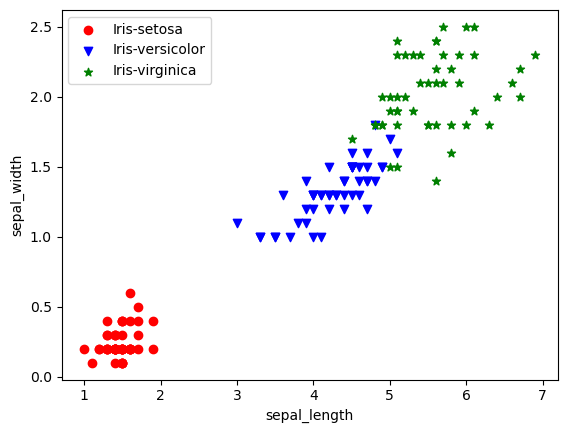

In [22]:
setosa     = iris['class'] == 'Iris-setosa'
versicolor = iris['class'] == 'Iris-versicolor'
virginica  = iris['class'] == 'Iris-virginica'

plt.scatter(Xiris[setosa,     0], Xiris[setosa,     1], color='red'  , marker='o', label='Iris-setosa'    )
plt.scatter(Xiris[versicolor, 0], Xiris[versicolor, 1], color='blue' , marker='v', label='Iris-versicolor')
plt.scatter(Xiris[virginica,  0], Xiris[virginica,  1], color='green', marker='*', label='Iris-virginica' )

plt.xlabel('sepal_length')
plt.ylabel('sepal_width' )
plt.legend()
plt.show()

**TODO : Analyser les résultats**
- Que remarquez-vous concernant la séparabilité des 3 classes?
- Donner une hypothèse concernant la performance d'un modèle de classement comme la régression logistique sur ce dataset (Rappel, Précision)
- Justifier cette hypothèse (Rappel, Précision) en comparant les 3 classes

**Réponse**
- Les classes semblent visuellement séparables. La classe setosa est facilemenet séparable des autres classes, les classes versicolor et verginica semblent se chevaucher dans une petite région du plan 
- La perforamnce devrait être bonne (Rappel~1 et Précision~1).
- D'après ce qu'on voit les classes sont bien disctincts entre elles donc on peut s'atteindre à ce que les algorithmes de classifications vont construire de bonnes frontière de décision.

### II.3. One-vs-Rest OU MaxEnt

Nous avons entrainé deux modèles : 
1. **One-vs-Rest** : ici, trois sous-modèles binaires sont entraînés ; un pour chaque class. Chaque sous modèle détecte si l'échantillon appartient à sa classe ou non. Lors de la prédiction, on prend la classe avec le max de probabilité
1. **MaxEnt** : ici, un modèle de régression logistique multinomiale (maximum entropy) est entraîné pour séparer les trois classes


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics      import classification_report

one2rest = LogisticRegression(solver='lbfgs', penalty=None, multi_class='ovr'        )
one2one  = LogisticRegression(solver='lbfgs', penalty=None, multi_class='multinomial')

one2rest.fit(Xiris_train, Yiris_train)
one2one .fit(Xiris_train, Yiris_train)

print('One-vs-Rest')
print(classification_report(Yiris_test, one2rest.predict(Xiris_test)))

print('MaxEnt')
print(classification_report(Yiris_test, one2one.predict(Xiris_test)))

One-vs-Rest
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.91      1.00      0.95        10
 Iris-virginica       1.00      0.90      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30

MaxEnt
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



**TODO : Analyser les résultats**

Nous remarquons que la performance de MaxEnt est meilleure que celle de One-vs-Rest
- Pourquoi ? (en se basant sur la limite de décision et les paramètres)
- Quelle est l'approche (parmi ces deux) qui est affectée beaucoup plus par les valeurs aberrantes (les échantillons d'une classe qui peuvent se retrouver aux milieu d'une autre classe)

**Réponse**
- Le modèle MaxEnt crée une frontière de décision plus complexe par rapport à ovr (qui ne crée que de simple droites qui ne sont pas adaptées à des classes non linéairement séparables), aussi Softmax(MaxEnt) considère les intérractions entres les classes de par le partage de paramètres entres les différentes probabilitées de chaque classe grâce à la dévision des $e^{Z}$ sur  ${\sum\limits_{k=1}^{L} e^{Z_k}}$
- OVR.

### II.4. One-vs-Rest OU One-vs-One

Nous avons entrainé deux modèles : 
1. One-vs-Rest
1. One-vs-One

Les deux modèles sont comparés en se basant sur plusieurs critères.

In [42]:
# https://goshippo.com/blog/measure-real-size-any-python-object/
import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [53]:
from sklearn.metrics    import accuracy_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.exceptions import ConvergenceWarning
import sys, timeit
# ce block du code est pour filtrer les avertissements concernant la convergence du modèle
# en général, lorsque e nombre des itérations n'est pas suffisant pour atteindre l'erreur minimale
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

ovr = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=100, penalty=None, n_jobs=1))
ovo = OneVsOneClassifier (LogisticRegression(solver='lbfgs', max_iter=100, penalty=None, n_jobs=1))

temps_train = []

temps_debut = timeit.default_timer()
ovr.fit(Xbody_train, Ybody_train)
temps_train.append(timeit.default_timer() - temps_debut)

temps_debut = timeit.default_timer()
ovo.fit(Xbody_train, Ybody_train)
temps_train.append(timeit.default_timer() - temps_debut)

temps_test = []

temps_debut = timeit.default_timer()
ovr_res     = ovr.predict(Xbody_test)
temps_test.append(timeit.default_timer() - temps_debut)

temps_debut = timeit.default_timer()
ovo_res     = ovo.predict(Xbody_test)
temps_test.append(timeit.default_timer() - temps_debut)

taille = [get_size(ovr), get_size(ovo)]

accuracy = [
    accuracy_score(Ybody_test, ovr_res),
    accuracy_score(Ybody_test, ovo_res)
]


pd.DataFrame({
    'Algorithme'            : ['OvR', 'OvO']  ,
    'Taille'                : taille,
    'Temps d\'entrainement' : temps_train,
    'Temps de test'         : temps_test,
    'Accuracy'              : accuracy,
})

,Algorithme,Taille,Temps d'entrainement,Temps de test,Accuracy
0,OvR,6662,0.320735,0.001051,0.591639
1,OvO,8248,0.284131,0.003700,0.614408


In [54]:
print('One-vs-Rest')
print(classification_report(Ybody_test, ovr_res))

print('One-vs-One')
print(classification_report(Ybody_test, ovo_res))

One-vs-Rest
              precision    recall  f1-score   support

           A       0.61      0.84      0.71       670
           B       0.46      0.32      0.37       669
           C       0.50      0.39      0.44       670
           D       0.70      0.82      0.76       670

    accuracy                           0.59      2679
   macro avg       0.57      0.59      0.57      2679
weighted avg       0.57      0.59      0.57      2679

One-vs-One
              precision    recall  f1-score   support

           A       0.66      0.74      0.70       670
           B       0.46      0.44      0.45       669
           C       0.53      0.52      0.52       670
           D       0.81      0.75      0.78       670

    accuracy                           0.61      2679
   macro avg       0.61      0.61      0.61      2679
weighted avg       0.61      0.61      0.61      2679



**TODO : Analyser les résultats**

- Pourquoi la taille OvO est plus grande que celle de OvR ?
- Le temps d'entrainement est différent d'une exécution à une autre. Quand est-ce que un modèle est plus rappide que l'autre ?
- Par contre, le temps de test OvO est plus lourd. Pourquoi?
- Si nous pouvons paralleliser tous les modèles binaires, quel est l'effet sur les deux ?
- Pourquoi OvO généralise-t-il mieux que OvR ?
- Pouvons-nous utiliser OvR pour multi-label ? Pourquoi/Comment ?
- Pouvons-nous utiliser OvO pour multi-label ? Pourquoi/Comment ?

**Réponse**
- La taille du OvO est plus grande que OvR car le nombre de paramètres du OvO est plus important dû au fait que dans OvR on entraine $L$ modèle de régression logistique tandis que dans OvO On entraine $\frac{L*(L-1)}{2}$ donc plus de paramètres.
- Comme le nombre de classes est petit (4) ovo converge plus vite que ovr car ovo entraine $\frac{4 * (4-1)}{2} = 6$ modèles avec des petites taille de donées (relativement) tandis que ovr entraine certes $ 4 \lt 6$ modèles mais avec des donées de plus grandes tailles.
- ovo est plus lourd car pour chaque individus de test il faut le faire passer par 6 modèles avant de prendre la décision, alors que pour ovr on va le faire passer par seulement 4 modèles.
- les deux cas: 
1. Entrainement: dans le cas de parallélisme parfait dans l'entrainement des deux modèles, ovo devrait toujours êtres plus rapide car son temps va dépandre uniquement du temps d'entrainement du modèle parmis les L*(L-1)/2 avec la proportion de données la plus grande qui sera toujours inferieur à celle de tous le dataset, alors qu'ovr qui lui utilise tous le dataset.
2. test: Les deux modèles vont avoir le même temps de test, car dans la phase des tests on ne fait que calculer les probabilitées.
- Par ce que ovo prend on considération lors de prise de décision toutes les interracions deux à deux entres toutes les classes.
- Oui, en utilisant l'algorithme binary relevence où on fixe un threshold __de proba__ et pour chacun des $L$ modèles, si la probabilité d'appartenir à la classe positive est supérieur au threshold, on prend la classe positive comme un des labels.  
- Oui, on utilisant Pair-wise où on fixe un threshold de __nombre de votes__ et pour chacun des $\frac{L*(L-1)}{2}$ modèles, si le nombre de votes pour une classe est supérieur au threshold, on prend la classe comme un des labels.  